### TODO:
- Run Models with different parameters for all different dates in sepparate
- Tune parameters
- Add random oversampling method
- Find way to make random variable transformations

In [141]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

from sklearnext.tools import report_model_search_results
from sklearnext.over_sampling import SMOTE, GeometricSMOTE, RandomOverSampler
from sklearnext.model_selection import ModelSearchCV

from imblearn.pipeline import Pipeline

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../data/raw/tabexport2.csv', delimiter=';')

new_columns = {}
for col in df.columns[1:]:
    new_columns[col] = (col.replace('LC08_L1TP_204032_2015', '')[:4]+'_'+col[-1:])[1:]
df = df.rename(columns=new_columns)
df.to_csv('../data/interim/data.csv', index=False)

In [102]:
df.groupby('class').size()

class
A    131
B    270
C    761
D    296
E    185
F     37
G     10
H      4
dtype: int64

![class labels](https://ec.europa.eu/eurostat/statistics-explained/images/9/99/LUCAS_-_classification_of_land_cover.png)

In [75]:
# Degree of Dimensionality
DoD = lambda sample_size, features: sample_size/features
ft = len(df.columns)-1 # -1 is used to disregard the column "class"
df.groupby('class').size().apply(lambda sample_size: DoD(sample_size, ft))

class
A     2.729167
B     5.625000
C    15.854167
D     6.166667
E     3.854167
F     0.770833
G     0.208333
H     0.083333
dtype: float64

In [76]:
# Imbalance Ratio
IR = lambda majority_class, class_label: majority_class/class_label
majority_class = df.groupby('class').size().max()
df.groupby('class').size().apply(lambda class_size: IR(majority_class, class_size))

class
A      5.809160
B      2.818519
C      1.000000
D      2.570946
E      4.113514
F     20.567568
G     76.100000
H    190.250000
dtype: float64

In [3]:
report = pandas_profiling.ProfileReport(df, correlation_threshold=0.9)
report

Number of variables,49
Number of observations,1694
Total Missing (%),0.0%
Total size in memory,648.6 KiB
Average record size in memory,392.0 B
Numeric,16
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,32


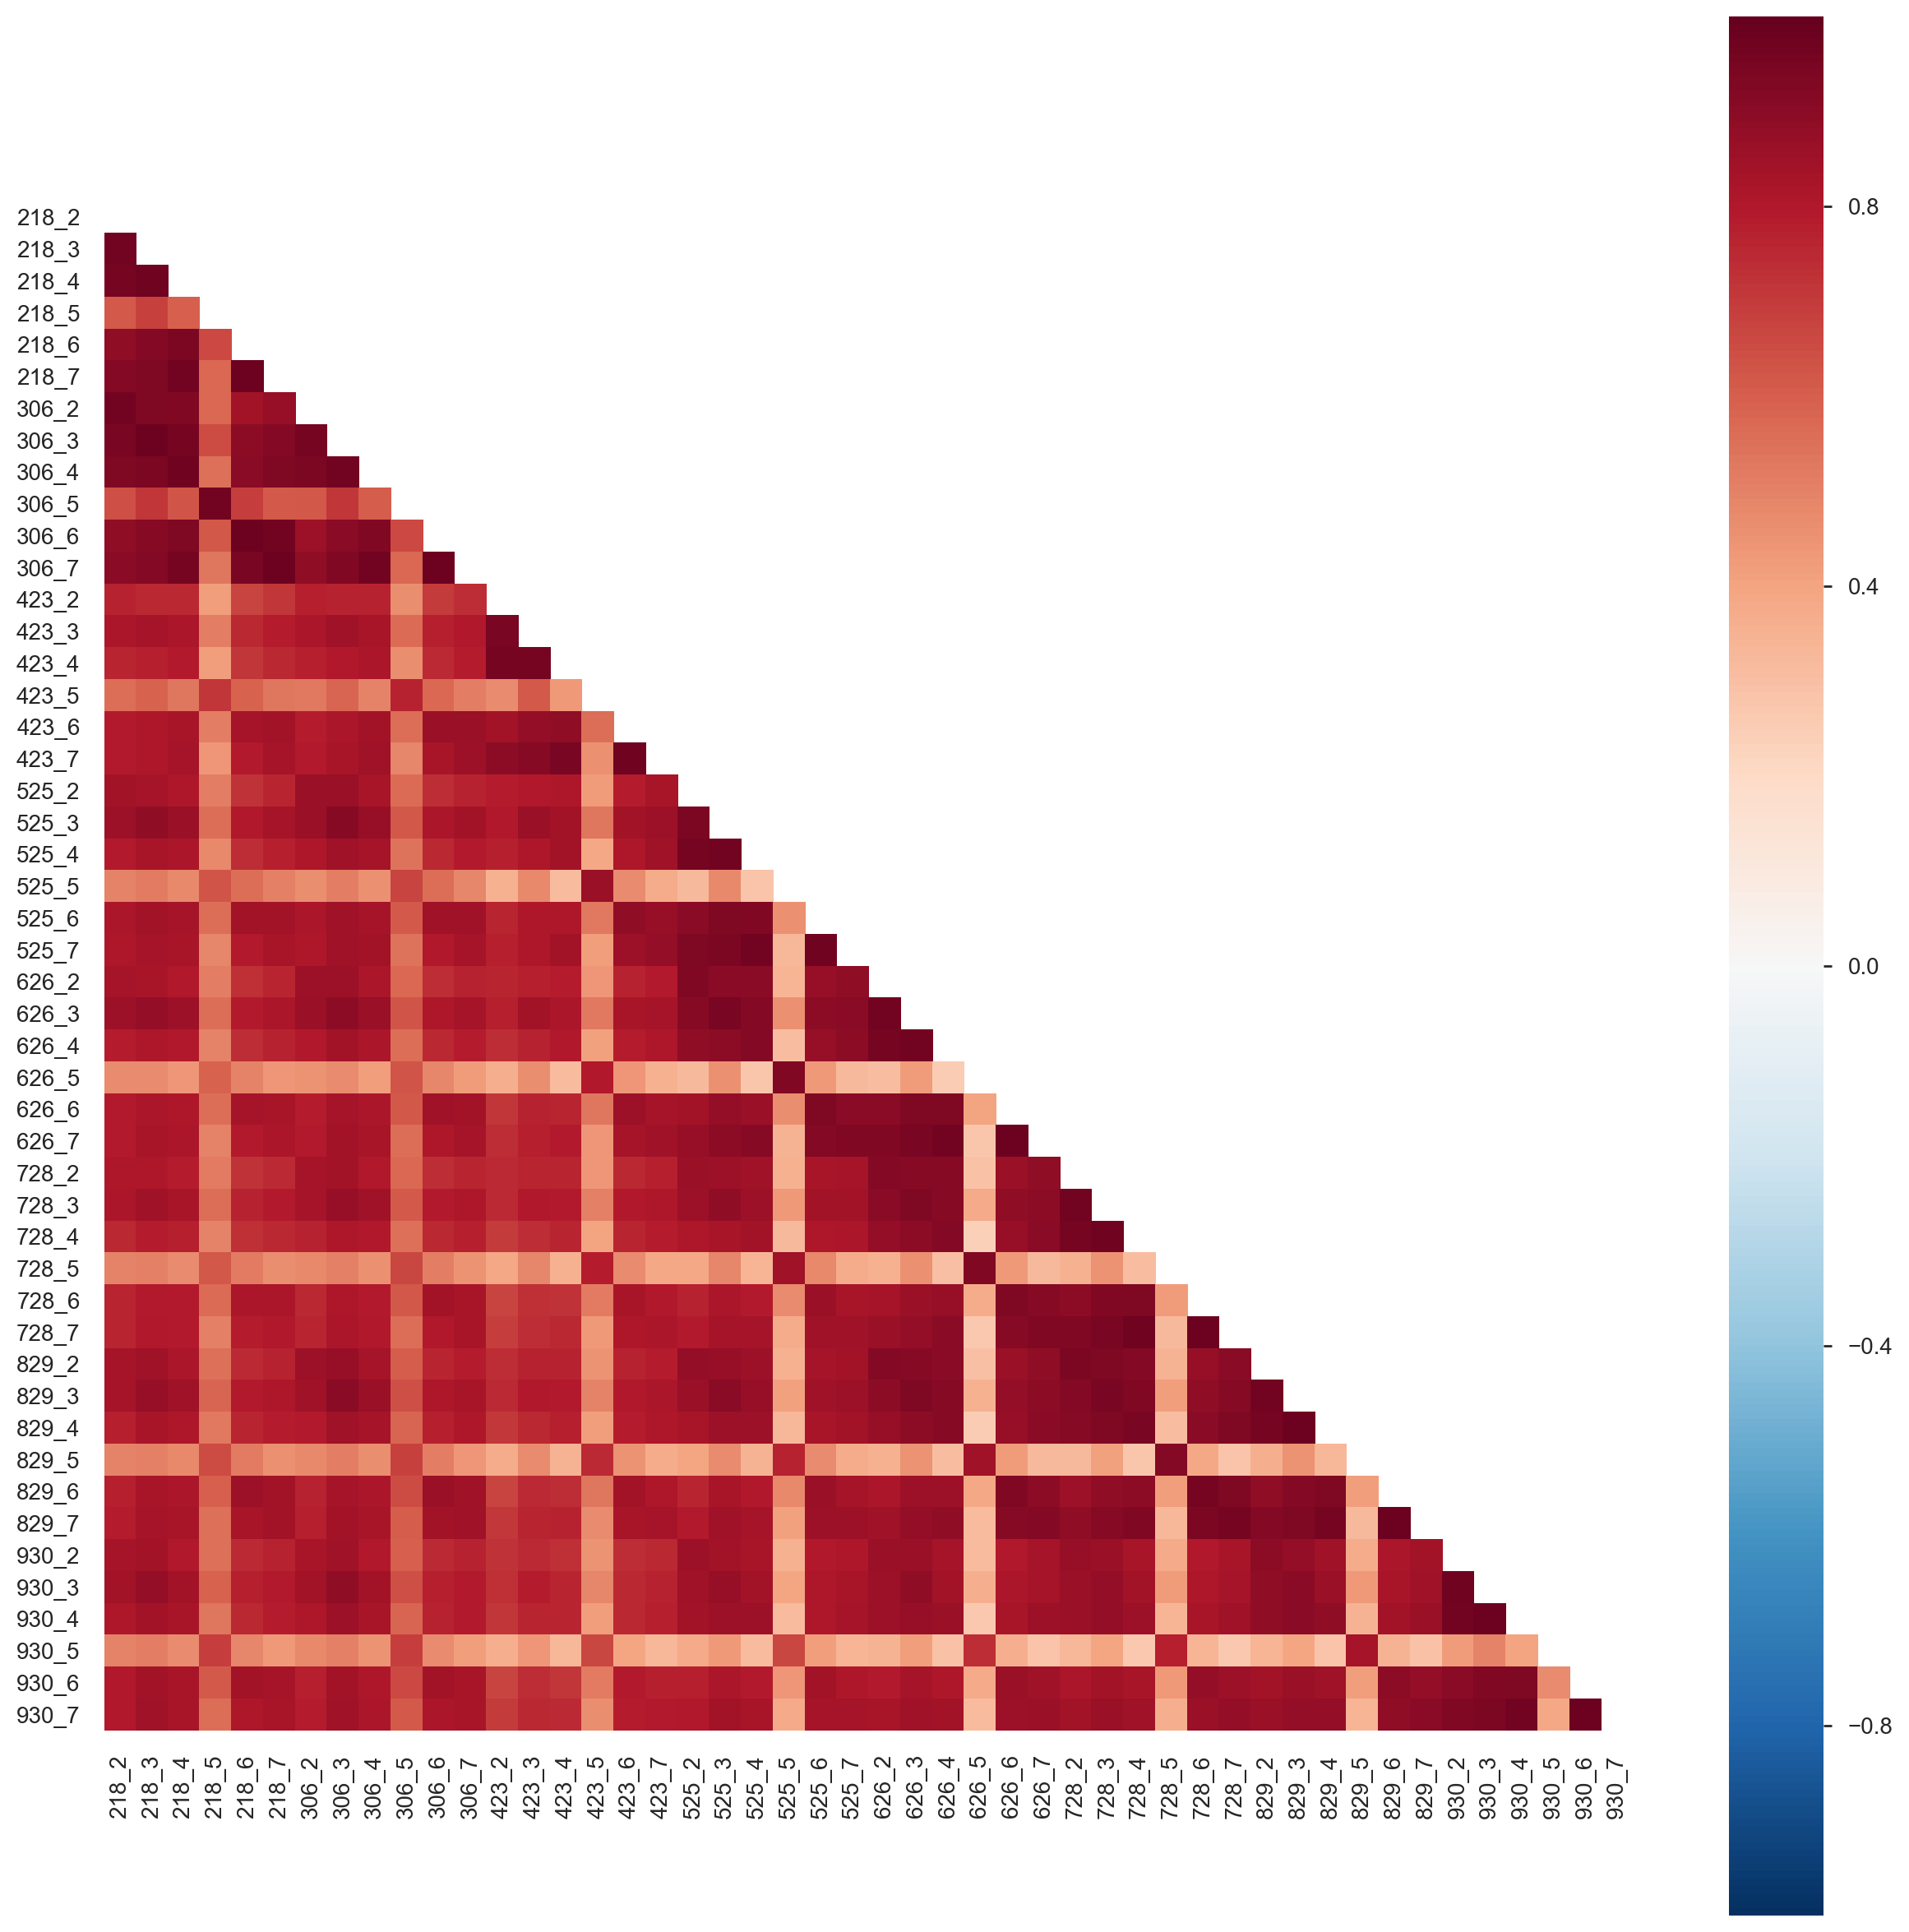

In [18]:
def make_corr_table(df, method='spearman', fig_size=(15,15)):
    corr = df.corr(method=method)
    # remove the upper diagonal of the correlation matrix
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        fig, ax = plt.subplots()
        fig.set_size_inches(fig_size[0], fig_size[1])
        sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, ax=ax, cmap='RdBu_r')
    
    
make_corr_table(df)

## Preprocessing stage
- Take highly correlated variable pairs (threshold ρ=0.9)
- Standardize them
- Run PCA on transformed variables
- Keep as many features as necessary such that the minimum explained variability criteria is met

**Note**: Which other features can we extract from this?

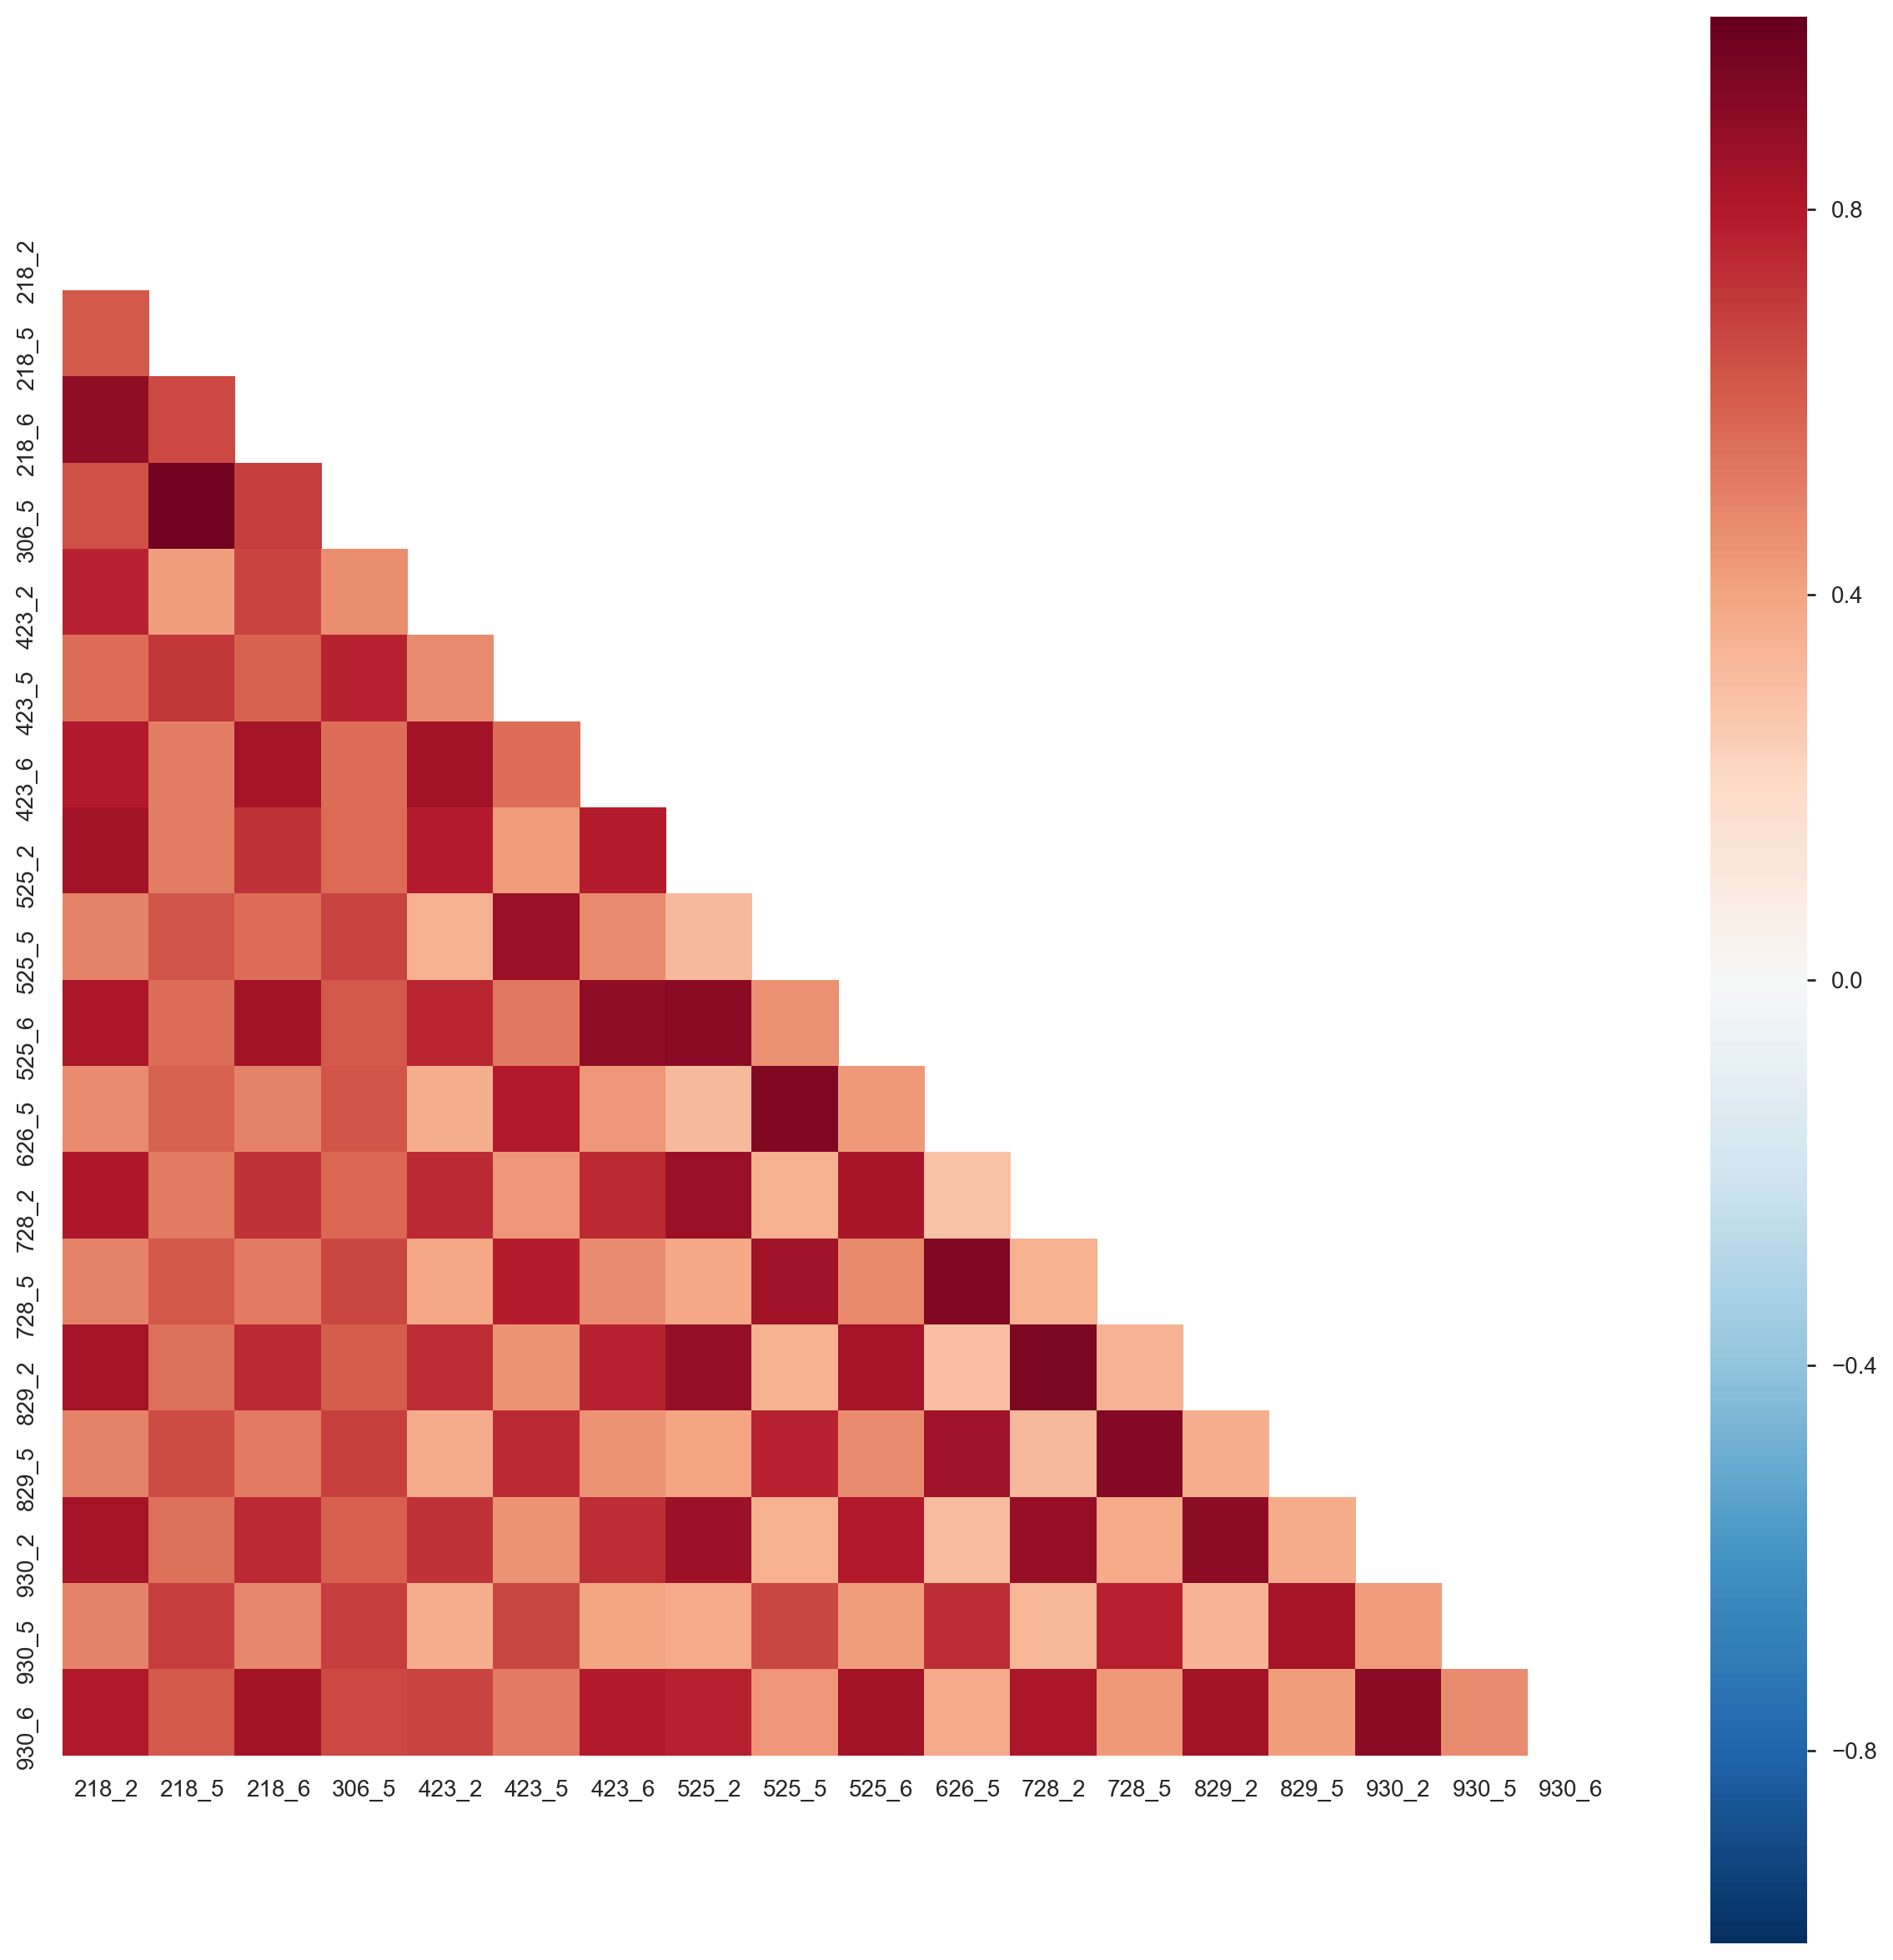

In [20]:
rejected_variables = report.get_rejected_variables()
rejected_variables.remove('306_5')
rejected_variables.remove('626_5')

make_corr_table(df.drop(columns=rejected_variables))
#make_corr_table(df.loc[:,rejected_variables])

In [136]:
obs_lost_percentage = df[df['class'].isin(['F', 'G', 'H'])].groupby('class').size().sum() / df.groupby('class').size().sum()

df2 = df[~df['class'].isin(['F', 'G', 'H'])]
print('Dropped {0:.2f}% of total observations.'.format(obs_lost_percentage*100))


Dropped 3.01% of total observations.


In [16]:
X = df2.drop(columns='class')
y = df2['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# question: Is it a good idea to make additional PCA on other variables with high correlation?
X_train_1 = X_train.drop(columns=rejected_variables)
X_train_2 = X_train.loc[:,rejected_variables]

X_test_1 = X_test.drop(columns=rejected_variables)
X_test_2 = X_test.loc[:,rejected_variables]

# standardize highly correlated data
sc = StandardScaler()
X_train_2[X_train_2.columns] = sc.fit_transform(X_train_2)  
X_test_2[X_test_2.columns] = sc.transform(X_test_2)

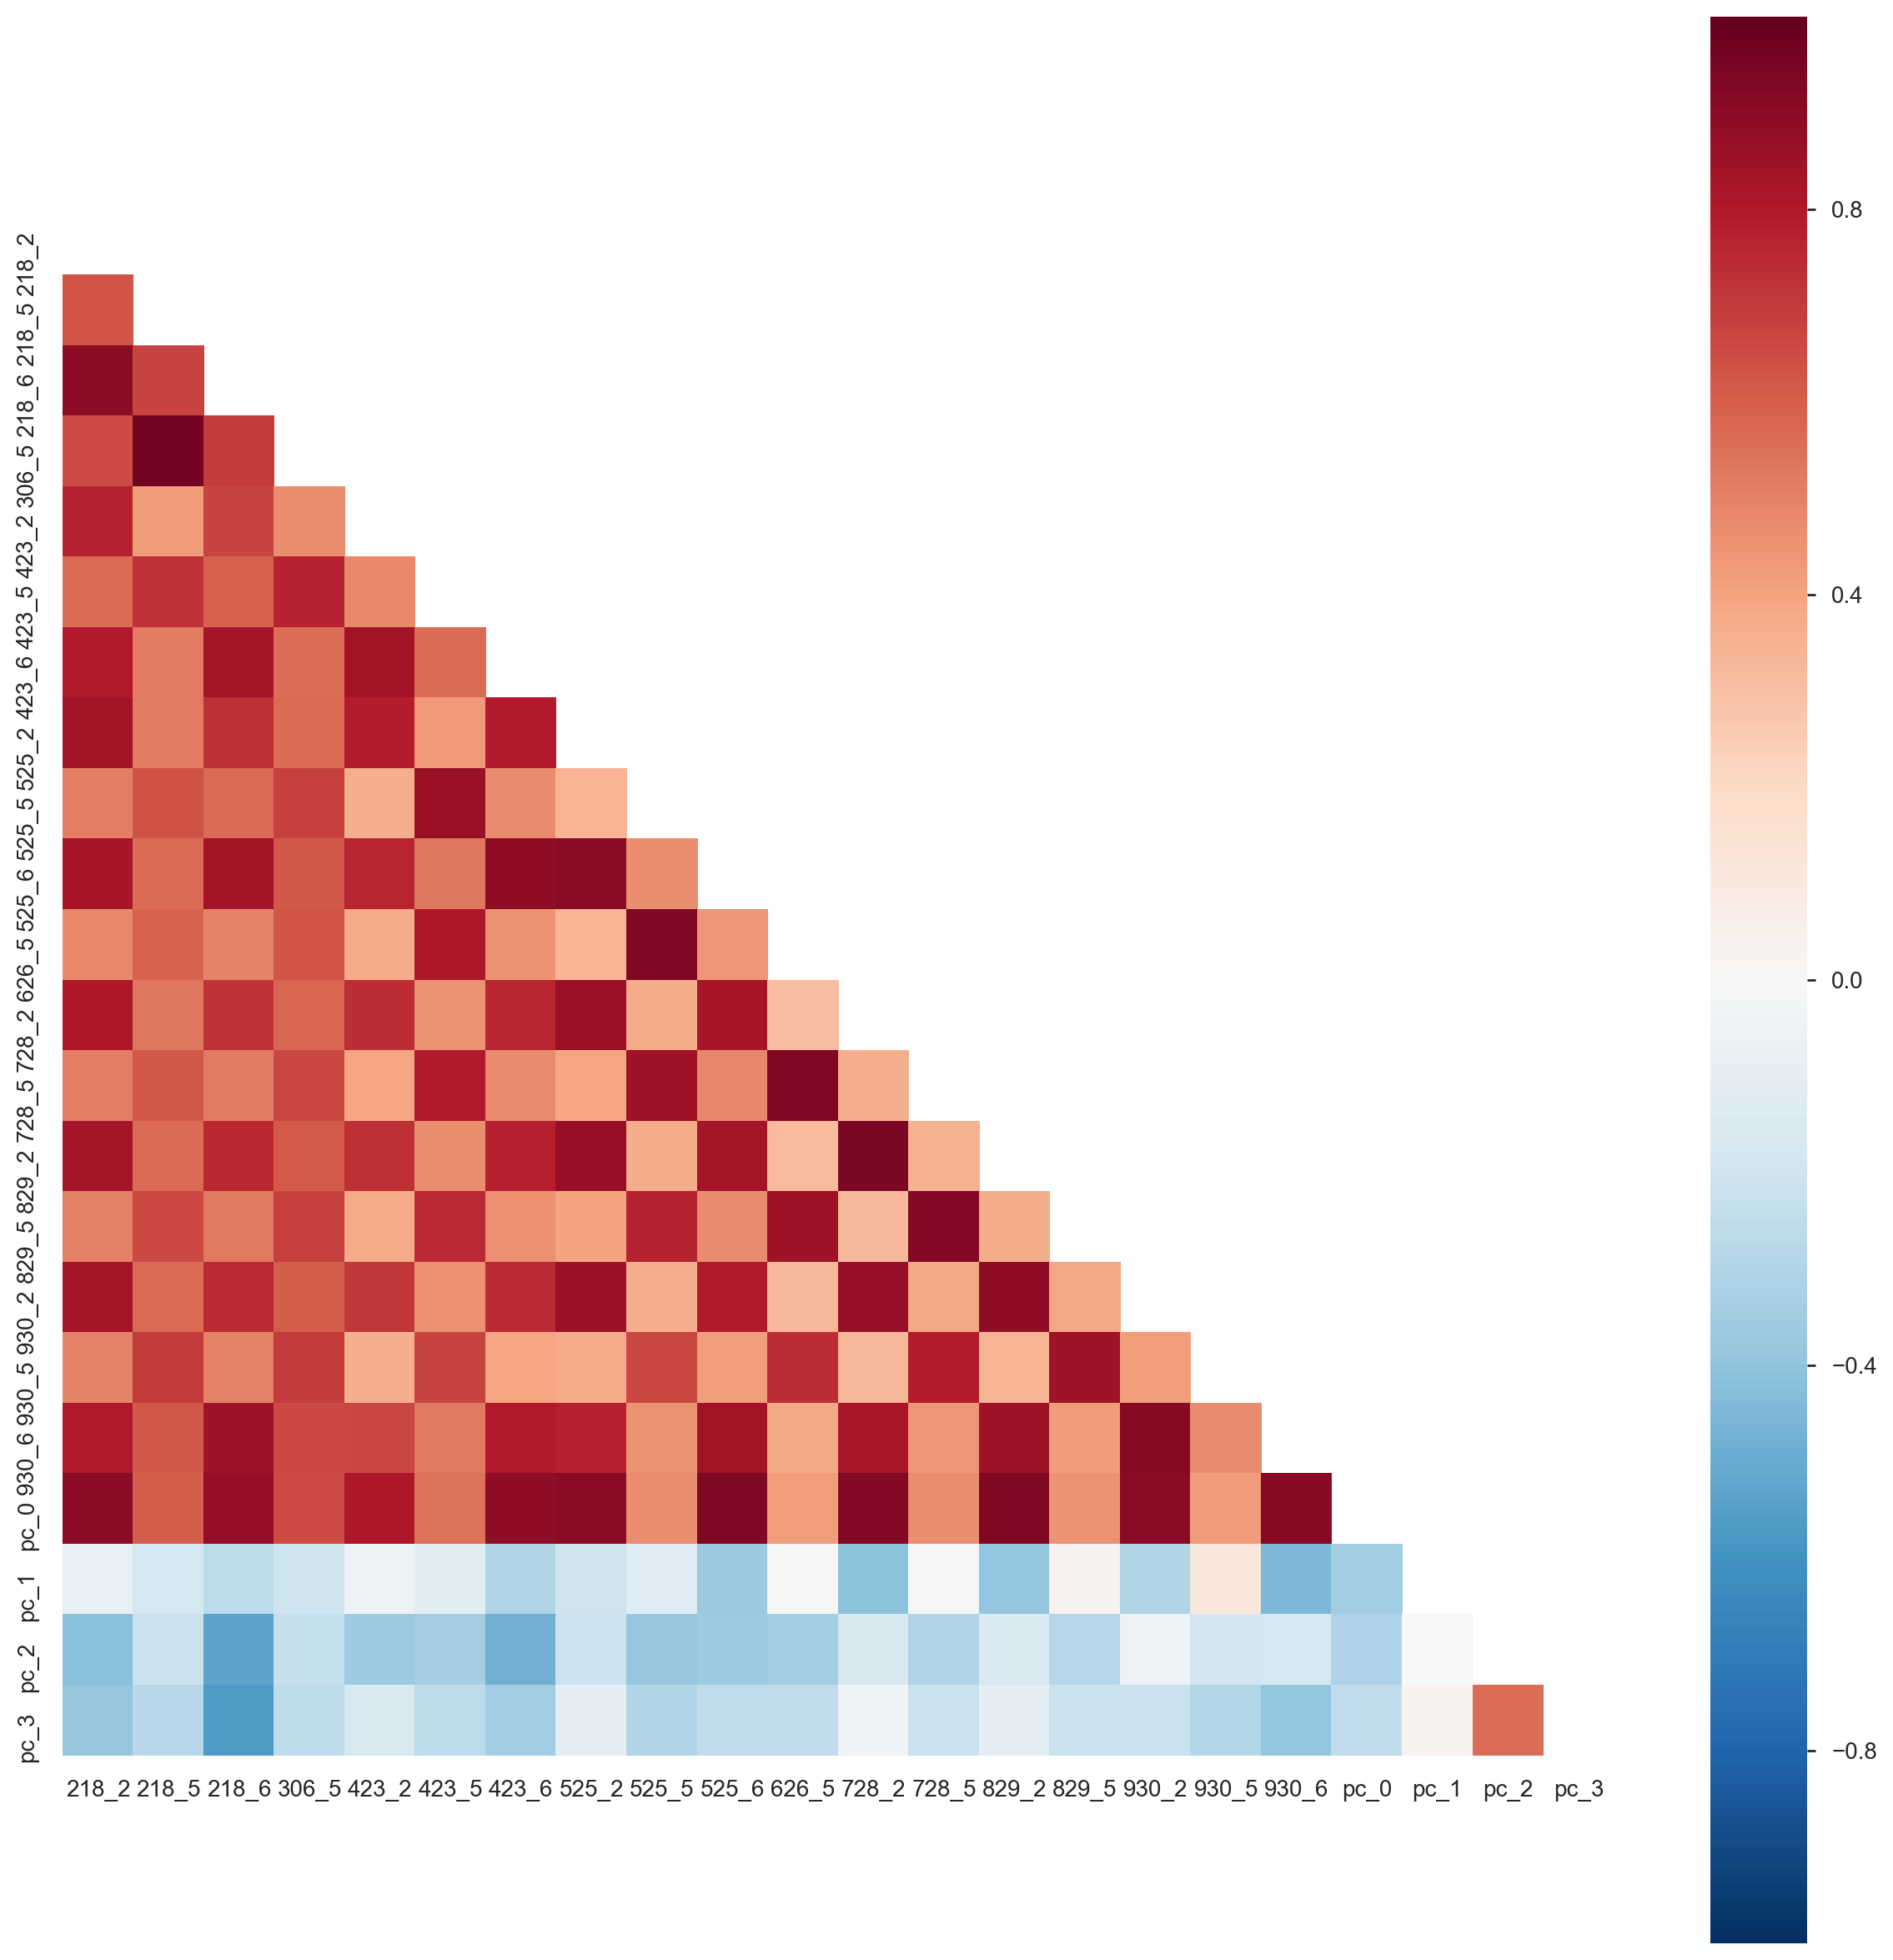

In [19]:
min_var = 0.95

old_cols = list(X_train_2.columns)

# Run PCA on standardized data
pca = PCA()
train_2 = pca.fit_transform(X_train_2)
test_2 = pca.transform(X_test_2)

# % of explained variance for each additional feature
np.cumsum(pca.explained_variance_ratio_)
# Get column name for the principal components' tables
pc_cols  = [f'pc_{i}' for i in range(np.where(np.cumsum(pca.explained_variance_ratio_) > min_var)[0][0])]
# Number of features to keep to get {min_var}% of explained variability
for i in range(np.where(np.cumsum(pca.explained_variance_ratio_) > min_var)[0][0]):
    X_train_2[f'pc_{i}'] = train_2[:,i]
    X_test_2[f'pc_{i}']  = test_2[:,i]

# build final dataset
X_train_final = X_train_1.join(X_train_2[pc_cols], on=None, how='outer')
X_test_final  = X_test_1.join(X_test_2[pc_cols])
make_corr_table(X_train_final)

## Modelling
### Standard Approach

In [115]:
def model_search(X, y, approach='standard'):
    """
    Function built for convenience purposes. oversamplers, classifiers etc etc must be edited in the function itself,
    if necessary.
    """
    global oversamplers, classifiers, pre_params, param_grids, estimators
    
    oversamplers = [
        ('none', None),
        ('RandomOverSampler', RandomOverSampler()),
        ('smote', SMOTE()),
        ('gsmote', GeometricSMOTE())
    ]

    classifiers = [
        #('MLP', MLPClassifier(activation='logistic', 
        #                      solver='lbfgs')),
        ('DT', DecisionTreeClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('RF', RandomForestClassifier()),
        ('LR', LinearRegression()),
        ('SVC', SVC())

    ]


    # missing parameters for DT, KNN and RF --> doing it later
    pre_params = {
        'smote': {'k_neighbors': [2, 3, 4, 5]},
        'gsmote': {
            'k_neighbors': [2, 3, 4, 5],
            'deformation_factor': [0.25, 0.50, 0.75],
            'truncation_factor': [-0.5, 0.0, 0.5]
        },
        #'MLP': {
        #    'alpha': [0.0001, 0.001, 0.01, 0.1],
        #    'hidden_layer_sizes': [(64,64), (150), (75), (150, 150)],
        #    'activation': ['relu', 'tanh', 'logistic'],
        #},
        'DT':{'criterion':['gini', 'entropy']},
        'KNN':{'n_neighbors':[3,4,5,6,7,8], 'criterion':['gini', 'entropy']},
        'RF':{'n_estimators':[10,30,50,70,100]}
        'SVC':{
            'kernel':['poly', 'rbf'],
            'degree':[1,2,3,4]
        },
    }

    param_grids = []
    estimators = []
    
    for oversampler in oversamplers:
        for classifier in classifiers:

            # sets up pipeline with name
            name = f'{oversampler[0]}+{classifier[0]}'
            if approach == 'standard':
                estimators.append((name, Pipeline([oversampler, classifier])))
            elif approach == 'onevsrest':
                estimators.append((name, OneVsRestClassifier(Pipeline([oversampler, classifier]))))
            elif approach == 'onevsone':
                estimators.append((name, OneVsOneClassifier(Pipeline([oversampler, classifier]))))
                

            # sets up param grid for the estimator
            param_grid = {}
            if oversampler[0] in pre_params.keys(): 
                for key, value in pre_params[oversampler[0]].items():
                    if approach == 'standard':
                        param_grid[f'{name}__{oversampler[0]}__{key}'] = value
                    elif approach in ['onevsrest', 'onevsone']:
                        param_grid[f'{name}__estimator__{oversampler[0]}__{key}'] = value

            if classifier[0]  in pre_params.keys(): 
                for key, value in pre_params[classifier[0]].items():
                    if approach == 'standard':
                        param_grid[f'{name}__{classifier[0]}__{key}'] = value
                    elif approach in ['onevsrest', 'onevsone']:
                        param_grid[f'{name}__estimator__{classifier[0]}__{key}'] = value
            if len(param_grid)>0:
                param_grids.append(param_grid)


    model_search_cv = ModelSearchCV(
        estimators=estimators, 
        param_grids=param_grids, 
        scoring=['f1_weighted', 'geometric_mean_score', 'accuracy'], 
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        refit=False, 
        n_jobs=-1
    )

    model_search_cv.fit(X, y)

    return model_search_cv

In [77]:
model_search_cv = model_search(X_train_final, y_train, approach='standard')
report_model_search_results(model_search_cv).sort_values('mean_test_f1_weighted', ascending=False)

,models,params,mean_fit_time,mean_test_f1_weighted,mean_test_geometric_mean_score,mean_test_accuracy
0,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",0.247875,0.349081,0.0,0.411417
1,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",0.737399,0.331597,0.0,0.318898
2,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",0.528998,0.387205,0.0,0.389108
3,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",1.641208,0.405298,0.0,0.398294
4,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",0.364804,0.413032,0.0,0.419291
5,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",1.242317,0.434778,0.0,0.438320
6,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",0.149188,0.175044,0.0,0.218504
7,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.00...",0.888924,0.296779,0.0,0.311680
8,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.01...",0.432566,0.401952,0.0,0.395013
9,none+MLP,"{'MLP__activation': 'relu', 'MLP__alpha': 0.01...",0.791078,0.357735,0.0,0.361549


### One-vs-rest approach

In [ ]:
model_search_cv_OVR = model_search(X_train_final, y_train, approach='onevsrest')
report_model_search_results(model_search_cv_OVR).sort_values('mean_test_f1_weighted', ascending=False)

### One-vs-One approach

In [ ]:
model_search_cv_OVO = model_search(X_train_final, y_train, approach='onevsone')
report_model_search_results(model_search_cv_OVO).sort_values('mean_test_f1_weighted', ascending=False)

In [143]:
DecisionTreeClassifier().get_params()


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}